# This is the baseline model of the project


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/sign-language-interpretation')

### The first step is to import the necessary library

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
from sklearn.metrics import accuracy_score
from sklearn.model_selection import  cross_validate, train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Rescaling,Dropout,BatchNormalization,RandomZoom, RandomRotation,RandomTranslation
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.regularizers import L1,L2,L1L2
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras import layers

### Read the train and test data

In [4]:
df_train = pd.read_csv('raw_data/sign_mnist_train.csv')
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [5]:
df_test = pd.read_csv('raw_data/sign_mnist_test.csv')
df_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [6]:
X = df_train.drop(columns='label')
y = df_train['label'].copy()
print(X.shape,y.shape)

(27455, 784) (27455,)


In [7]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,stratify=y,random_state = 42)
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)

(21964, 784) (5491, 784) (21964,) (5491,)


In [8]:
X_test = df_test.drop(columns='label')
y_test = df_test['label'].copy()
print(X_test.shape,y_test.shape)

(7172, 784) (7172,)


In [9]:
X_train_reshape = np.reshape(np.array(X_train), (X_train.shape[0],28,28))
X_val_reshape = np.reshape(np.array(X_val),(X_val.shape[0],28,28))
X_test_reshape = np.reshape(np.array(X_test),(X_test.shape[0],28,28))
print(X_train_reshape.shape,X_val_reshape.shape,X_test_reshape.shape)

(21964, 28, 28) (5491, 28, 28) (7172, 28, 28)


In [10]:
X_train_dim = expand_dims(X_train_reshape)
X_val_dim = expand_dims(X_val_reshape)
X_test_dim = expand_dims(X_test_reshape)
print(X_train_dim.shape,X_val_reshape.shape,X_test_dim.shape)

(21964, 28, 28, 1) (5491, 28, 28) (7172, 28, 28, 1)


In [11]:
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)
print(y_train_cat.shape,y_val_cat.shape,y_test_cat.shape)

(21964, 25) (5491, 25) (7172, 25)


In [12]:
y_val.value_counts()

17    259
16    256
11    248
22    245
5     241
18    240
14    239
3     239
19    237
23    233
20    232
8     232
13    230
2     229
0     225
24    224
10    223
6     218
15    218
21    216
12    211
7     203
1     202
4     191
Name: label, dtype: int64

## The first model just use the more complicated model, with some dropout to avoid overfitting

In [13]:
def initialize_model1():
    adam = Adam(learning_rate=0.001)
    model = Sequential()
    # Add an scaling layers to normalize the image
    model.add(Rescaling(1./255,input_shape = (28,28,1)))

    ### First Convolution & MaxPooling
    model.add(Conv2D(75, kernel_size = (3,3),activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2),padding = 'same'))
    
    ### Second Convolution & MaxPooling
    model.add(Conv2D(50, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2),padding = 'same'))


    ### Third Convolution & MaxPooling
    model.add(Conv2D(25, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(Dropout(0.2))
    model.add(MaxPool2D(pool_size = (2,2),padding = 'same'))

    ### Flattening
    model.add(Flatten())
    
    ### One Fully Connected layer - "Fully Connected" is equivalent to saying "Dense"
    model.add(Dense(512,activation = 'relu'))
    model.add(Dropout(0.3))
    
    ### Last layer - Classification Layer with 10 outputs corresponding to 10 digits
    model.add(Dense(25,activation = 'softmax'))
    
    ### Model compilation
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics = ['accuracy'])
    
    return model

In [53]:
es = EarlyStopping(patience = 2, restore_best_weights = True,verbose=0)
reduc_lr = ReduceLROnPlateau(patience=2,verbose=1)

In [58]:
cnn_model_01 = initialize_model1()

In [59]:
history1 = cnn_model_01.fit(X_train_dim, y_train_cat,epochs=20,batch_size=128,validation_data = (X_val_dim,y_val_cat),callbacks=[es,reduc_lr])

Epoch 1/20
172/172 [==============================] - 4s 11ms/step - loss: 1.8900 - accuracy: 0.4216 - val_loss: 0.5660 - val_accuracy: 0.8488 - lr: 0.0010
Epoch 2/20
172/172 [==============================] - 2s 9ms/step - loss: 0.3805 - accuracy: 0.8698 - val_loss: 0.1096 - val_accuracy: 0.9729 - lr: 0.0010
Epoch 3/20
172/172 [==============================] - 2s 9ms/step - loss: 0.1359 - accuracy: 0.9555 - val_loss: 0.0285 - val_accuracy: 0.9984 - lr: 0.0010
Epoch 4/20
172/172 [==============================] - 2s 9ms/step - loss: 0.0620 - accuracy: 0.9816 - val_loss: 0.0105 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/20
172/172 [==============================] - 2s 10ms/step - loss: 0.0411 - accuracy: 0.9876 - val_loss: 0.0085 - val_accuracy: 0.9987 - lr: 0.0010
Epoch 6/20
172/172 [==============================] - 2s 11ms/step - loss: 0.0256 - accuracy: 0.9928 - val_loss: 0.0039 - val_accuracy: 0.9996 - lr: 0.0010
Epoch 7/20
172/172 [==============================] - 2s 10ms/step 

In [60]:
results1 = cnn_model_01.evaluate(X_test_dim,y_test_cat)
results1

225/225 [==============================] - 1s 3ms/step - loss: 0.1437 - accuracy: 0.9587


[0.14370176196098328, 0.9587283730506897]

In [61]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

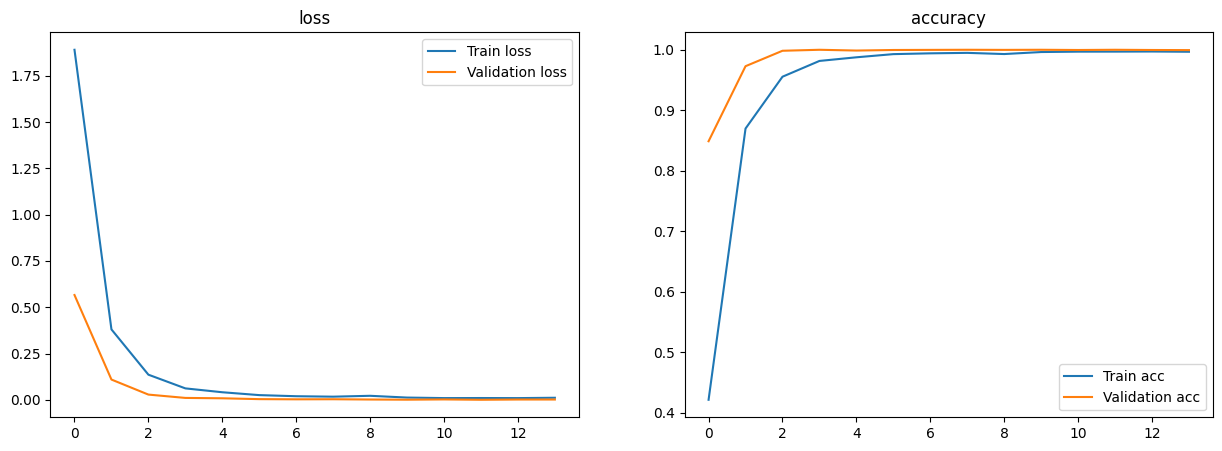

In [62]:
plot_history(history1)

In [63]:
def initialize_model2():

    model = Sequential()
    # Add an scaling layers to normalize the image
    model.add(Rescaling(1./255,input_shape = (28,28,1)))

    ### First Convolution & MaxPooling
    model.add(Conv2D(75, kernel_size = (3,3),activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (2,2),padding = 'same'))
    
    ### Second Convolution & MaxPooling
    model.add(Conv2D(50, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (2,2),padding = 'same'))


    ### Third Convolution & MaxPooling
    model.add(Conv2D(25, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (2,2),padding = 'same'))

    ### Flattening
    model.add(Flatten())
    
    ### One Fully Connected layer - "Fully Connected" is equivalent to saying "Dense"
    model.add(Dense(512,activation = 'relu'))
    model.add(Dropout(0.3))
    
    ### Last layer - Classification Layer with 10 outputs corresponding to 10 digits
    model.add(Dense(25,activation = 'softmax'))
    
    ### Model compilation
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics = ['accuracy'])
    
    return model

In [64]:
cnn_model_02 = initialize_model2() 

In [65]:
history2 = cnn_model_02.fit(X_train_dim, y_train_cat,epochs=20,batch_size=128,validation_data = (X_val_dim,y_val_cat),callbacks=[es,reduc_lr])

Epoch 1/20
172/172 [==============================] - 5s 15ms/step - loss: 0.8127 - accuracy: 0.7555 - val_loss: 3.3777 - val_accuracy: 0.0390 - lr: 0.0010
Epoch 2/20
172/172 [==============================] - 2s 13ms/step - loss: 0.0678 - accuracy: 0.9812 - val_loss: 1.7831 - val_accuracy: 0.4149 - lr: 0.0010
Epoch 3/20
172/172 [==============================] - 3s 15ms/step - loss: 0.0241 - accuracy: 0.9942 - val_loss: 0.2899 - val_accuracy: 0.9262 - lr: 0.0010
Epoch 4/20
172/172 [==============================] - 2s 14ms/step - loss: 0.0159 - accuracy: 0.9961 - val_loss: 0.0256 - val_accuracy: 0.9969 - lr: 0.0010
Epoch 5/20
172/172 [==============================] - 2s 13ms/step - loss: 0.0113 - accuracy: 0.9971 - val_loss: 0.0053 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/20
172/172 [==============================] - 2s 13ms/step - loss: 0.0103 - accuracy: 0.9969 - val_loss: 0.1252 - val_accuracy: 0.9568 - lr: 0.0010
Epoch 7/20
168/172 [============================>.] - ETA: 0s - 

In [66]:
results2 = cnn_model_02.evaluate(X_test_dim,y_test_cat)
results2

225/225 [==============================] - 1s 3ms/step - loss: 0.1363 - accuracy: 0.9568


[0.13628163933753967, 0.9567763805389404]

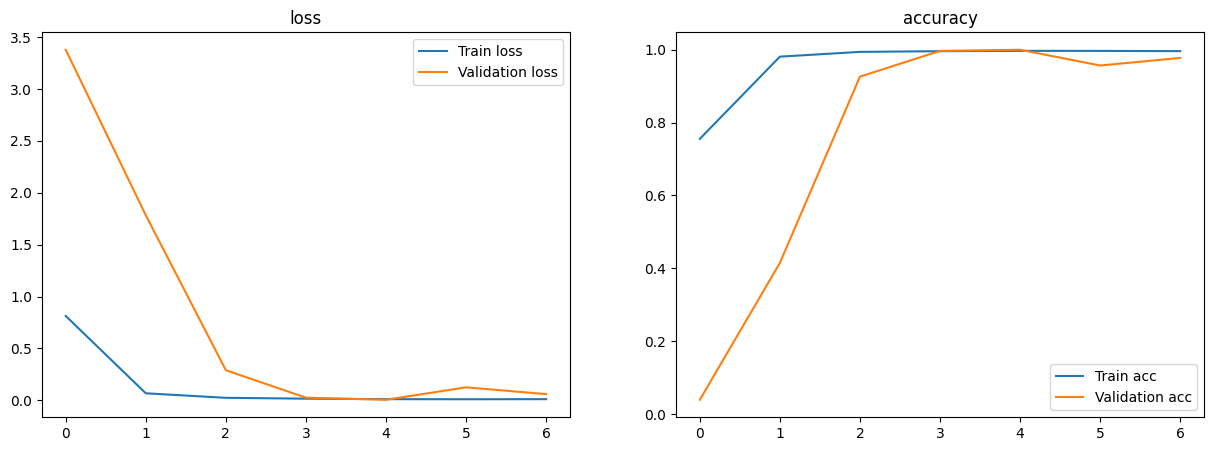

In [67]:
plot_history(history2)

In [68]:
def initialize_model3():

    model = Sequential()
    # Add an scaling layers to normalize the image
    model.add(Rescaling(1./255,input_shape = (28,28,1)))

    # Add Data Augmentation layers
    model.add(layers.RandomZoom(0.1))
    model.add(layers.RandomTranslation(0.1, 0.1))
    model.add(layers.RandomRotation(0.1))


    ### First Convolution & MaxPooling
    model.add(Conv2D(75, kernel_size = (3,3),activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (2,2),padding = 'same'))
    
    ### Second Convolution & MaxPooling
    model.add(Conv2D(50, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (2,2),padding = 'same'))


    ### Third Convolution & MaxPooling
    model.add(Conv2D(25, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (2,2),padding = 'same'))

    ### Flattening
    model.add(Flatten())
    
    ### One Fully Connected layer - "Fully Connected" is equivalent to saying "Dense"
    model.add(Dense(512,activation = 'relu'))
    model.add(Dropout(0.3))
    
    ### Last layer - Classification Layer with 10 outputs corresponding to 10 digits
    model.add(Dense(25,activation = 'softmax'))
    
    ### Model compilation
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics = ['accuracy'])
    
    return model

In [69]:
cnn_model_03 = initialize_model3() 

In [70]:
history3 = cnn_model_03.fit(X_train_dim, y_train_cat,epochs=20,batch_size=128,validation_data = (X_val_dim,y_val_cat),callbacks=[es,reduc_lr])

Epoch 1/20
172/172 [==============================] - 6s 17ms/step - loss: 1.8822 - accuracy: 0.4140 - val_loss: 3.9104 - val_accuracy: 0.0750 - lr: 0.0010
Epoch 2/20
172/172 [==============================] - 3s 15ms/step - loss: 0.8348 - accuracy: 0.7149 - val_loss: 3.3710 - val_accuracy: 0.1100 - lr: 0.0010
Epoch 3/20
172/172 [==============================] - 3s 15ms/step - loss: 0.5101 - accuracy: 0.8234 - val_loss: 0.9878 - val_accuracy: 0.6416 - lr: 0.0010
Epoch 4/20
172/172 [==============================] - 3s 17ms/step - loss: 0.3485 - accuracy: 0.8801 - val_loss: 0.2112 - val_accuracy: 0.9337 - lr: 0.0010
Epoch 5/20
172/172 [==============================] - 3s 15ms/step - loss: 0.2633 - accuracy: 0.9097 - val_loss: 0.2399 - val_accuracy: 0.9148 - lr: 0.0010
Epoch 6/20
172/172 [==============================] - 3s 15ms/step - loss: 0.2136 - accuracy: 0.9268 - val_loss: 0.1184 - val_accuracy: 0.9623 - lr: 0.0010
Epoch 7/20
172/172 [==============================] - 2s 14ms/st

In [71]:
c

225/225 [==============================] - 1s 3ms/step - loss: 0.1890 - accuracy: 0.9306


[0.18899989128112793, 0.9305633306503296]

In [79]:
def initialize_model4():

    model = Sequential()
    # Add an scaling layers to normalize the image
    model.add(Rescaling(1./255,input_shape = (28,28,1)))

    # Add Data Augmentation layers
    model.add(layers.RandomZoom(0.1))
    model.add(layers.RandomTranslation(0.1, 0.1))
    model.add(layers.RandomRotation(0.1))


    ### First Convolution & MaxPooling
    model.add(Conv2D(75, kernel_size = (3,3),activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(MaxPool2D(pool_size = (2,2),padding = 'same'))
    
    ### Second Convolution & MaxPooling
    model.add(Conv2D(50, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (2,2),padding = 'same'))


    ### Third Convolution & MaxPooling
    model.add(Conv2D(25, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (2,2),padding = 'same'))

    ### Flattening
    model.add(Flatten())
    
    ### One Fully Connected layer - "Fully Connected" is equivalent to saying "Dense"
    model.add(Dense(256,activation = 'relu'))
    model.add(Dropout(0.3))
    
    ### Last layer - Classification Layer with 10 outputs corresponding to 10 digits
    model.add(Dense(25,activation = 'softmax'))
    
    ### Model compilation
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics = ['accuracy'])
    
    return model

In [75]:
es2 = EarlyStopping(patience = 5, restore_best_weights = True,verbose=0)
reduc_lr2 = ReduceLROnPlateau(patience=5,verbose=1)

In [80]:
cnn_model_04 = initialize_model4() 

In [81]:
history4 = cnn_model_04.fit(X_train_dim, y_train_cat,epochs=50,batch_size=128,validation_data = (X_val_dim,y_val_cat),callbacks=[es2,reduc_lr2])

Epoch 1/50
172/172 [==============================] - 8s 19ms/step - loss: 2.3986 - accuracy: 0.2750 - val_loss: 4.2912 - val_accuracy: 0.0922 - lr: 0.0010
Epoch 2/50
172/172 [==============================] - 3s 16ms/step - loss: 1.3048 - accuracy: 0.5629 - val_loss: 3.1863 - val_accuracy: 0.2306 - lr: 0.0010
Epoch 3/50
172/172 [==============================] - 3s 16ms/step - loss: 0.8583 - accuracy: 0.7047 - val_loss: 1.4451 - val_accuracy: 0.5280 - lr: 0.0010
Epoch 4/50
172/172 [==============================] - 3s 19ms/step - loss: 0.6092 - accuracy: 0.7898 - val_loss: 0.7167 - val_accuracy: 0.7334 - lr: 0.0010
Epoch 5/50
172/172 [==============================] - 3s 17ms/step - loss: 0.4818 - accuracy: 0.8329 - val_loss: 0.7349 - val_accuracy: 0.7492 - lr: 0.0010
Epoch 6/50
172/172 [==============================] - 3s 16ms/step - loss: 0.3860 - accuracy: 0.8662 - val_loss: 0.9434 - val_accuracy: 0.6968 - lr: 0.0010
Epoch 7/50
172/172 [==============================] - 3s 16ms/st

In [82]:
results4 = cnn_model_04.evaluate(X_test_dim,y_test_cat)
results4

225/225 [==============================] - 1s 3ms/step - loss: 0.1314 - accuracy: 0.9640


[0.13144126534461975, 0.9640267491340637]

In [83]:
cnn_model_04.save('./cnn_model/cnn_model_01')

In [84]:
def initialize_model5():

    model = Sequential()
    # Add an scaling layers to normalize the image
    model.add(Rescaling(1./255,input_shape = (28,28,1)))

    # Add Data Augmentation layers
    model.add(RandomZoom(0.1))
    model.add(RandomTranslation(0.1, 0.1))
    model.add(RandomRotation(0.2))



    ### First Convolution & MaxPooling
    model.add(Conv2D(75, kernel_size = (3,3),activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(MaxPool2D(pool_size = (2,2),padding = 'same'))
    
    ### Second Convolution & MaxPooling
    model.add(Conv2D(50, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (2,2),padding = 'same'))


    ### Third Convolution & MaxPooling
    model.add(Conv2D(25, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (2,2),padding = 'same'))

    ### Flattening
    model.add(Flatten())
    
    ### One Fully Connected layer - "Fully Connected" is equivalent to saying "Dense"
    model.add(Dense(256,activation = 'relu'))
    model.add(Dropout(0.3))
    
    ### Last layer - Classification Layer with 10 outputs corresponding to 10 digits
    model.add(Dense(25,activation = 'softmax'))
    
    ### Model compilation
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics = ['accuracy'])
    
    return model

In [87]:
cnn_model_05 = initialize_model5() 

In [88]:
history5 = cnn_model_05.fit(X_train_dim, y_train_cat,epochs=50,batch_size=128,validation_data = (X_val_dim,y_val_cat),callbacks=[es2,reduc_lr2])

Epoch 1/50
172/172 [==============================] - 7s 19ms/step - loss: 2.7071 - accuracy: 0.1925 - val_loss: 4.4882 - val_accuracy: 0.0370 - lr: 0.0010
Epoch 2/50
172/172 [==============================] - 3s 20ms/step - loss: 1.8529 - accuracy: 0.3972 - val_loss: 4.1954 - val_accuracy: 0.0843 - lr: 0.0010
Epoch 3/50
172/172 [==============================] - 3s 17ms/step - loss: 1.3226 - accuracy: 0.5480 - val_loss: 1.9985 - val_accuracy: 0.3728 - lr: 0.0010
Epoch 4/50
172/172 [==============================] - 3s 16ms/step - loss: 0.9970 - accuracy: 0.6570 - val_loss: 1.0613 - val_accuracy: 0.6227 - lr: 0.0010
Epoch 5/50
172/172 [==============================] - 3s 16ms/step - loss: 0.7872 - accuracy: 0.7268 - val_loss: 1.2210 - val_accuracy: 0.6048 - lr: 0.0010
Epoch 6/50
172/172 [==============================] - 3s 19ms/step - loss: 0.6719 - accuracy: 0.7630 - val_loss: 0.6841 - val_accuracy: 0.7549 - lr: 0.0010
Epoch 7/50
172/172 [==============================] - 3s 18ms/st

In [89]:
results5 = cnn_model_05.evaluate(X_test_dim,y_test_cat)
results5

225/225 [==============================] - 1s 3ms/step - loss: 0.3057 - accuracy: 0.8907


[0.3056783676147461, 0.8906859755516052]